<a href="https://colab.research.google.com/github/lillianpoland/hi-class/blob/main/LillPolaU8proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Project: Writing a BARTical

In [72]:
!pip install preliz
!pip install bambi
!pip install pymc-bart

In [73]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import preliz as pz
import seaborn as sns

In [74]:
Performance = pd.read_csv('https://raw.githubusercontent.com/lillianpoland/hi-class/refs/heads/main/StudentPerformanceFactors.csv').dropna()

In [75]:
Performance

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,25,69,High,Medium,No,7,76,Medium,Yes,1,High,Medium,Public,Positive,2,No,High School,Near,Female,68
6603,23,76,High,Medium,No,8,81,Medium,Yes,3,Low,High,Public,Positive,2,No,High School,Near,Female,69
6604,20,90,Medium,Low,Yes,6,65,Low,Yes,3,Low,Medium,Public,Negative,2,No,Postgraduate,Near,Female,68
6605,10,86,High,High,Yes,6,91,High,Yes,2,Low,Medium,Private,Positive,3,No,High School,Far,Female,68


I can assume which predictors will have the most effect, but making scatter plots will show the relationships in a simple way to help me choose my variable.

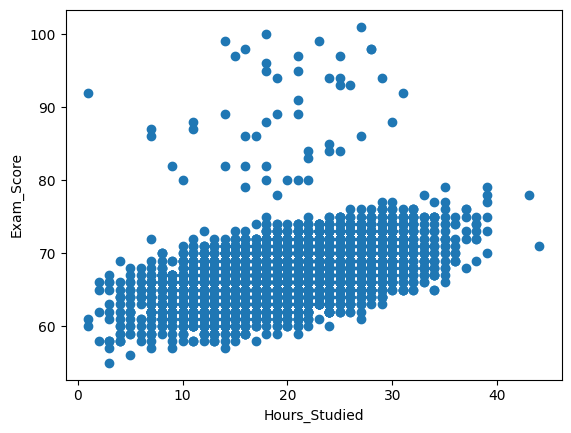

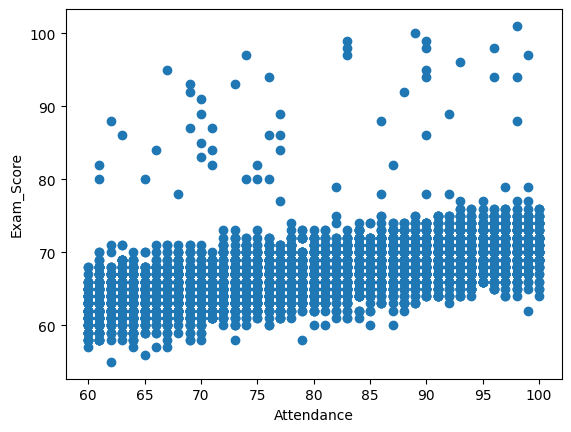

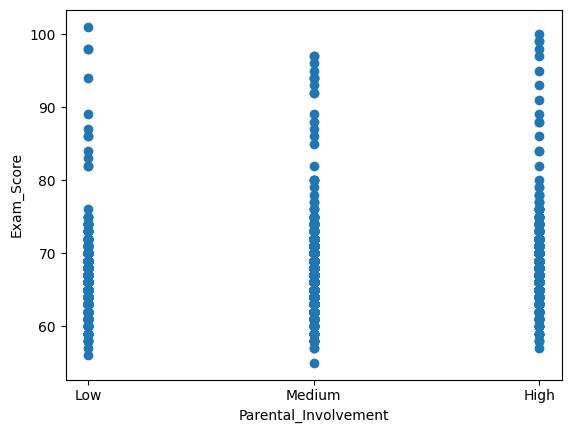

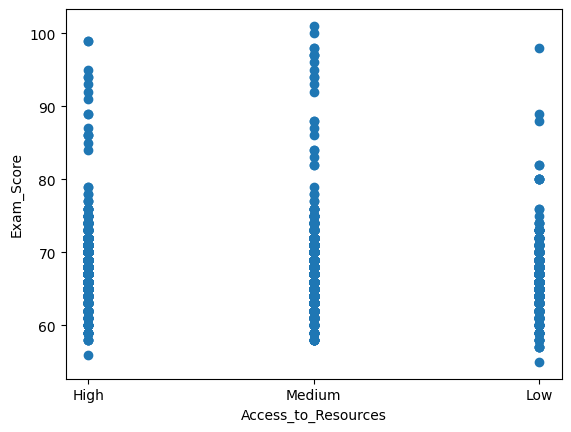

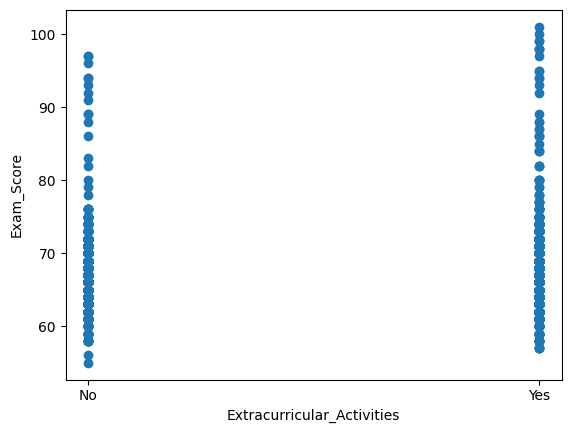

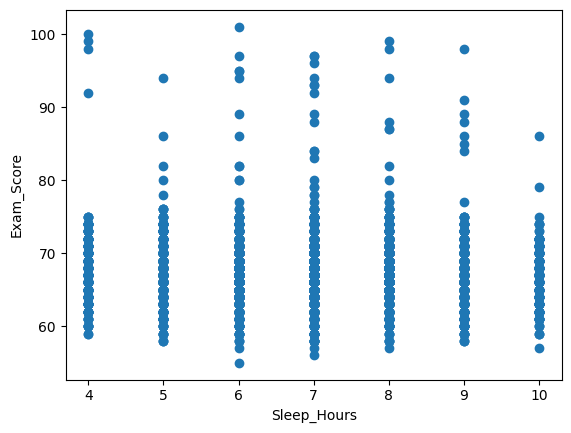

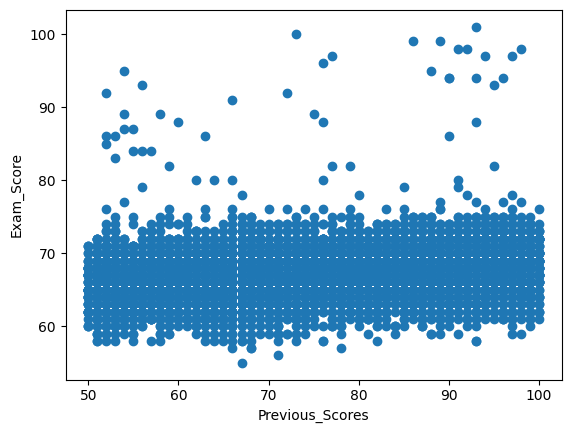

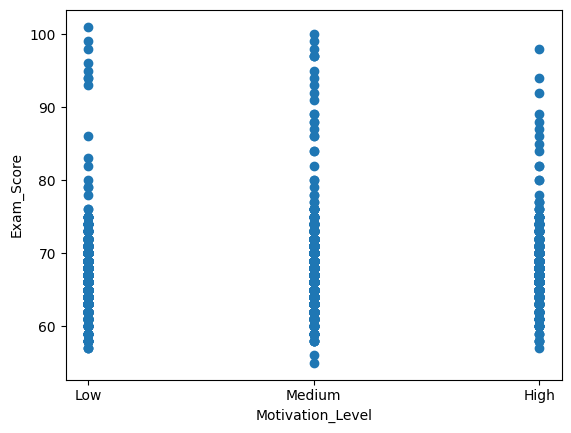

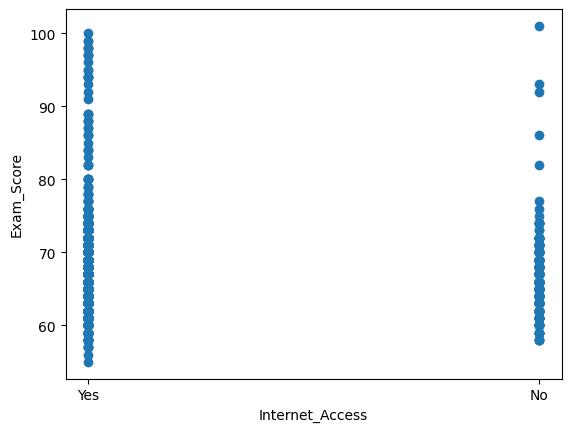

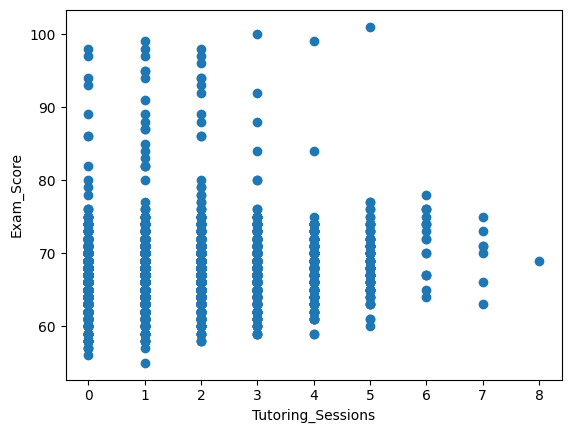

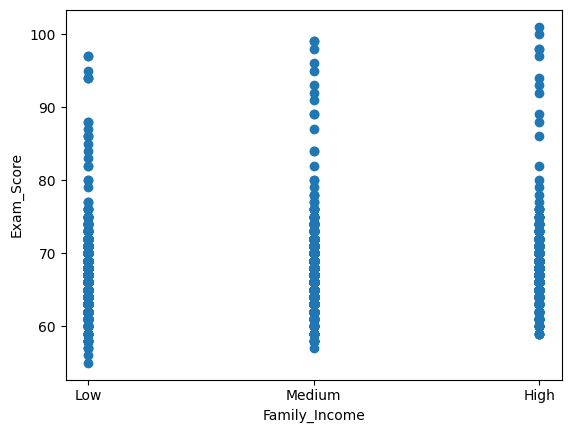

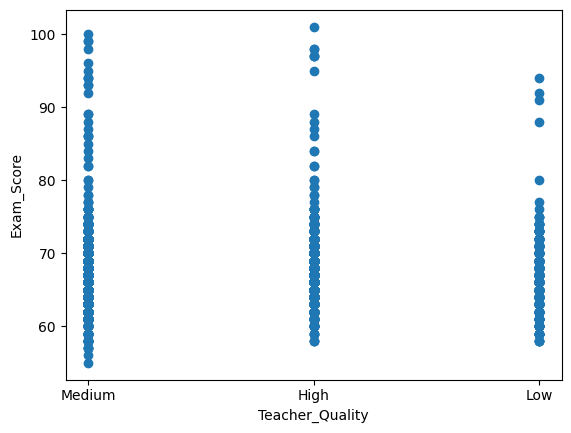

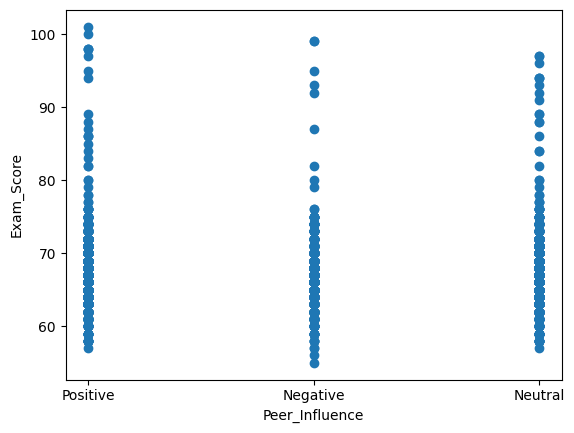

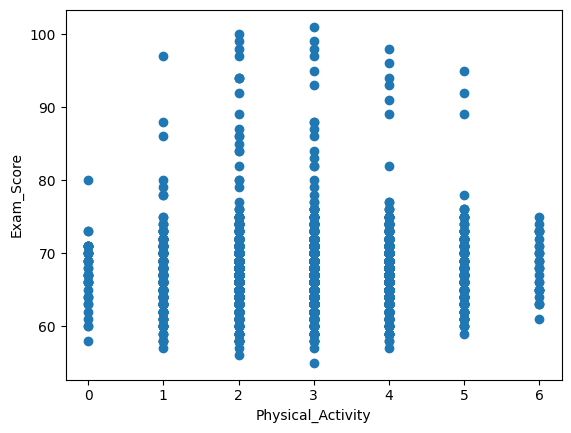

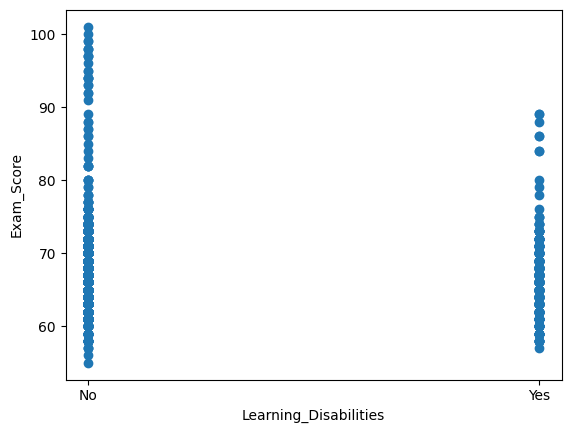

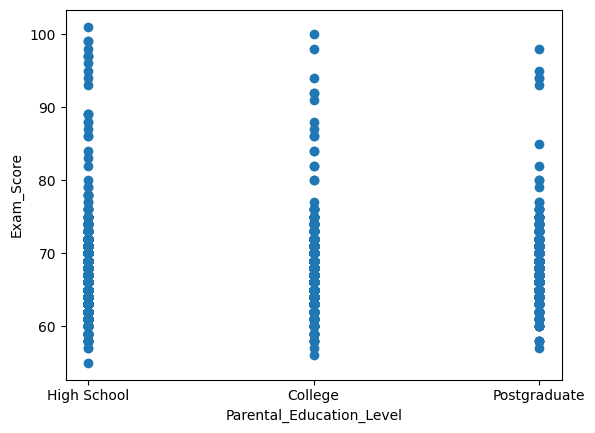

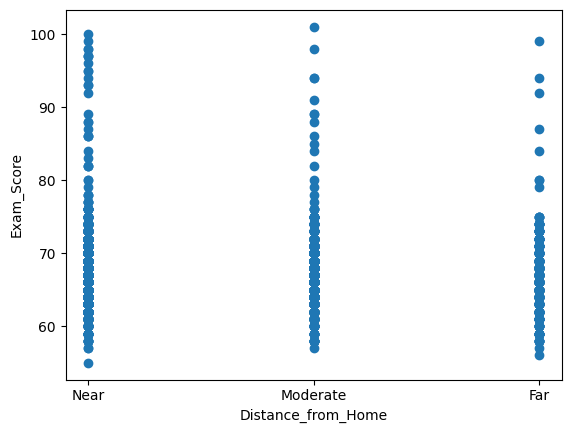

In [76]:
x = ["Hours_Studied", "Attendance", "Parental_Involvement", "Access_to_Resources", "Extracurricular_Activities", "Sleep_Hours", "Previous_Scores", "Motivation_Level", "Internet_Access", "Tutoring_Sessions", "Family_Income", "Teacher_Quality", "Peer_Influence", "Physical_Activity", "Learning_Disabilities", "Parental_Education_Level", "Distance_from_Home"]
y = "Exam_Score"
for a in x:
  plt.scatter(Performance[a], Performance[y])
  plt.xlabel(a)
  plt.ylabel(y)
  plt.show()

The scatter plots show that hours studied and attendance have the most direct positive and linear relationship with exam scores. Similarly, resoucres, internet access, teacher quality and distance from hoem
EXPLAIN hours studied, attendance, access to resources, internet access (binary), teacher quality, distance from home

<Axes: xlabel='Hours_Studied', ylabel='Exam_Score'>

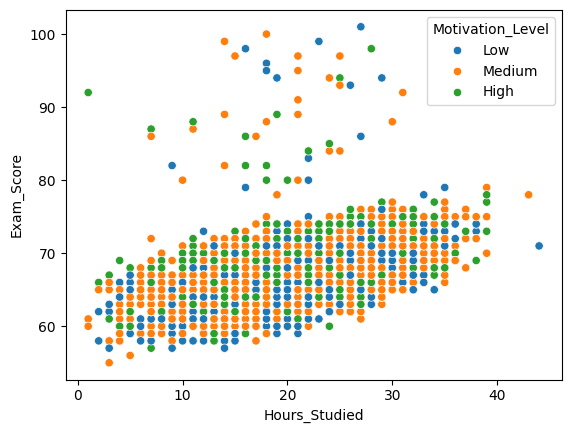

In [77]:
sns.scatterplot(data = Performance, y = 'Exam_Score', x = 'Hours_Studied', hue = 'Motivation_Level')

There is a general positive trend with Hours studied and Exam Score. The hue parameter allows us to see how motivation level influences the main trend. There are clumps of students with higher motivation level toward the upper end of the exam score range, even for similar study hours. On the other hand, points for students with lower motivation are more scattered and mainly lower on the exam score range, even if they have spent a long time studying. While it seems like studying more hours might cause higher exam scores, there could be other underlying factors influencing both. There are also a lot of outliers which could indivate special cases that go against the norm.

<Axes: xlabel='Attendance', ylabel='Exam_Score'>

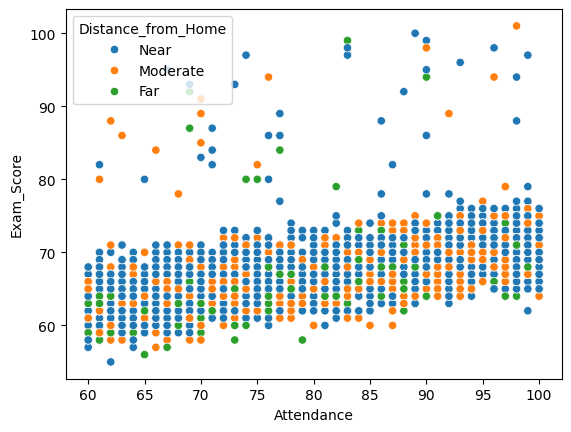

In [78]:
sns.scatterplot(data = Performance, y = 'Exam_Score', x = 'Attendance', hue = 'Distance_from_Home'
)

There is a general positive trend, but it is not as strong as the relationship between study hours and exam scores (the previous scatter plot). While there is a general positive trend for most distances, it would make sense that there are slight variations in the relationship between attendance and exam scores for students living at different distances. For example, if a student lives farther away they might have lower attendance and lower exam scores.

In [79]:
# Create a mapping for 'Motivation_Level'
motivation_mapping = {'Low': 0, 'Medium': 1, 'High': 2}

# Replace string values with numerical equivalents
Performance['Motivation_Level_Num'] = Performance['Motivation_Level'].map(motivation_mapping)

# Now use the numerical column in your X data
X = Performance[['Attendance', 'Motivation_Level_Num', 'Hours_Studied']]
Y = Performance["Exam_Score"].to_numpy()

Motivation Level was shown in low, medium, and high so I changed those to corresponding numerical values which will allow me to use motivation level in my models

In [80]:
with pm.Model() as model_PerformanceR:
    s = pm.HalfNormal('s', 20)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata_PerformanceR = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

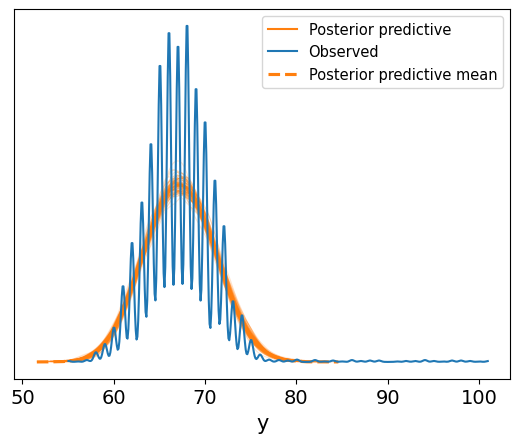

In [81]:
#generate the posterior predictive dist
pm.sample_posterior_predictive(idata_PerformanceR,model_PerformanceR, extend_inferencedata=True)
az.plot_ppc(idata_PerformanceR, num_pp_samples=100, colors=["C1", "C0", "C1"])

The BART model uses 50 (m=50) trees whose predictions are combined to create the overall prediction for a student's exam scores. The BART model is able to capture complex and non-linear relationships between the predictors and the exam scores. This is able to capture how studying hours on exam scores might be different for students with high motivation compared to low motivation. The narrow distribution indicates higher confidence, whereas wider would show more uncertainty. For example, if there was a positive skew that might suggest that the model thinks some students will score exceptionally high. The peaks could also show that the model found clusters within the data, like different patterns of exam scores for students with different levels of motivation of access to resources.

In [82]:
posterior_mean = idata_PerformanceR.posterior["μ"]

μ_hdi = az.hdi(ary=idata_PerformanceR, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_PerformanceR, group="posterior_predictive", var_names=["y"]
).T

In [83]:
# Create a mapping for 'Motivation_Level'
motivation_mapping = {'Low': 0, 'Medium': 1, 'High': 2}

# Replace string values with numerical equivalents
Performance['Motivation_Level_Num'] = Performance['Motivation_Level'].map(motivation_mapping)

# Now use the numerical column in X data
X = Performance[['Attendance', 'Motivation_Level_Num', 'Hours_Studied']].to_numpy()
Y = Performance["Exam_Score"].to_numpy()

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


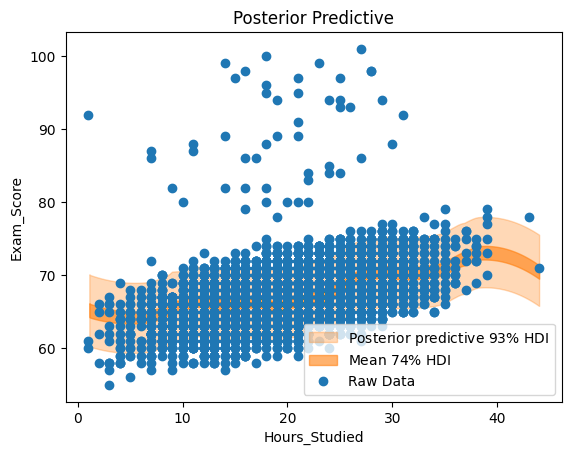

In [84]:
idx = np.argsort(X[:, 2]) # Sort by the third column ('Hours_Studied') which is index 2
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 2],  # Use the third column ('Hours_Studied') for x-axis
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X[:, 2],  # Use the third column ('Hours_Studied') for x-axis
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(Performance['Hours_Studied'], Performance["Exam_Score"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="Hours_Studied",
    ylabel="Exam_Score",
);

This graph shows an upward trend, which makes sense. As study hours increase, exam scores tend to increase as well. The HDI is wider at the lower study hours which shows greater uncertainty in the model for students who study less. There could be other factors influencing the scores such as motivation, test anxiety, or prior knowledge. The HDI is narrower at the higher study hours shows more confidence in the model's predictions. There is a lot of variance for the raw data poitns, which could mean that students with similar study hours can still achieve different exam scores. The outliers show that the model might not perfectly capture every student's performance, which could be due to unique circumstances.

array([<Axes: xlabel='X_0'>, <Axes: xlabel='X_1'>, <Axes: xlabel='X_2'>],
      dtype=object)

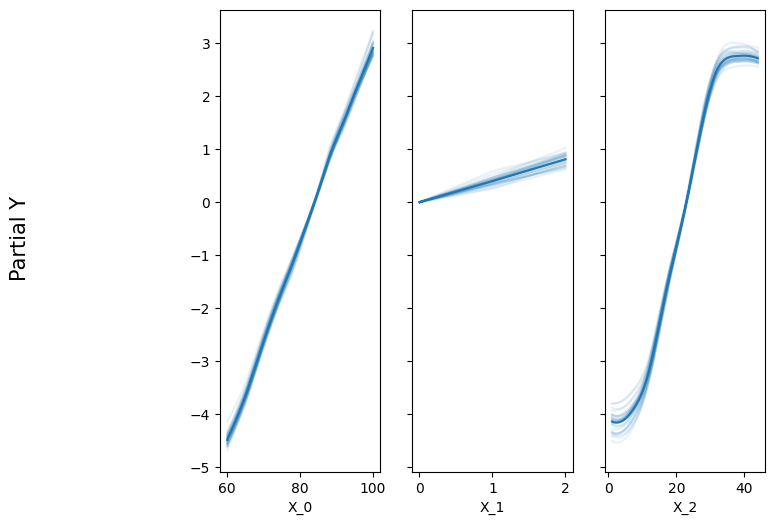

In [85]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

1. Attendance
2. Motivation Level
3. Hours studied

These ICE Plots show how the prediction for Exam Score changes based on how I vary one predictor, while keeping the other ones constant. Since the lines are not parallel it shows that there are interactions between the predictors. The non-parallelness shows that the interactions are more complex between the predictors and the target variable. This also highlights the importance of considering individual data points.  The ICE Plots are good because they show a more detailed view of the behavior of the model rather than just looking at big picture models.

The lines not being parallel shows that the effect of one predictor on the target depends on the value of another predictor. Plot 1 shows a very positive linear relationship, showing there could be low interaction between other variables. The 2nd plot shows distinct behavior per category, which makes sense because the values are 0, 1, and 2. Plot 3 is not linear and looks more like an S. This means the predictor might only affect the outcome when it passes a certain threshold.  


In [86]:
# Create a mapping for 'Parental_Involvement'
Parental_mapping = {'Low': 0, 'Medium': 1, 'High': 2}

# Replace string values with numerical equivalents
Performance['Parental_Involvement_Num'] = Performance['Parental_Involvement'].map(Parental_mapping)

In [87]:
# Create a mapping for 'Resources'
Resources_mapping = {'Low': 0, 'Medium': 1, 'High': 2}

# Replace string values with numerical equivalents
Performance['Access_to_Resources_Num'] = Performance['Access_to_Resources'].map(Resources_mapping)

In [88]:
# Create a mapping for 'Internet_Access'
Internet_mapping = {'No': 0, 'Yes': 1}

# Replace string values with numerical equivalents
Performance['Internet_Access_Num'] = Performance['Internet_Access'].map(Internet_mapping)

In [89]:
# Create a mapping for 'Extracurricular_Activities'
Activities_mapping = {'No': 0, 'Yes': 1}

# Replace string values with numerical equivalents
Performance['Extracurricular_Activities_Num'] = Performance['Extracurricular_Activities'].map(Activities_mapping)

In [90]:
#I combine all my predictor variables into one dataframe
X = Performance[[
             'Attendance',
             'Motivation_Level_Num',
             'Hours_Studied',
             'Parental_Involvement_Num',
             'Access_to_Resources_Num',
             'Extracurricular_Activities_Num',
             'Sleep_Hours',
             'Previous_Scores',
             'Internet_Access_Num',
             ]]#.to_numpy()
Y = Performance['Exam_Score'].to_numpy()

In [91]:
with pm.Model() as model_Performance:
    s = pm.HalfNormal('s',20) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_Performance = pm.sample(compute_convergence_checks=False)

Output()

In [92]:
pm.sample_posterior_predictive(idata_Performance,model_Performance, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 0.0005)

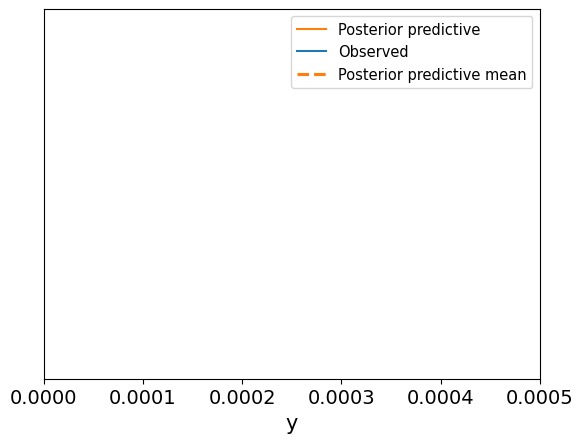

In [93]:
ax = az.plot_ppc(idata_Performance, num_pp_samples=100, colors=["C1", "C0", "C1"])
ax.set_xlim(0.0,0.0005)

This graph shows nothing, but it allows me to run the adaquete variable importance model with every single important variable instead of just attendance, motivation level, and hours studied.

In [94]:
vi_Performance = pmb.compute_variable_importance(idata_Performance, μ_, X)

<Axes: ylabel='R²'>

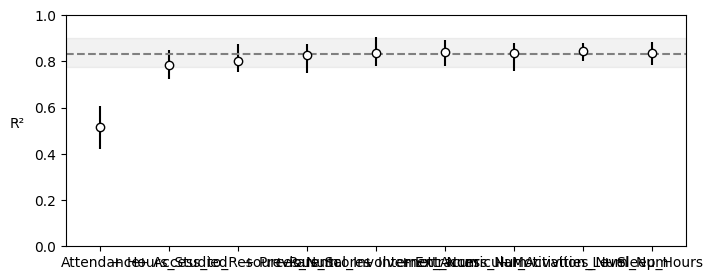

In [95]:
pmb.plot_variable_importance(vi_Performance)

While it is hard to read the variable names, I can tell that access to resources, extracurricular activities, and previous scores are performing the best. These variables did not show a specific pattern on the scatter plots, but BART models are able to capture the complex interactions or hidden relationships that are waiting to be uncovered. This means these variables could be non-linear relationships with the exam scores. The BART model is also able to account for interactions between variables. For example, Access to Resources might have a greater impact on students with lower previous scores. It makes sense that students with higher access to resources, like books, technology, and tutoring are going to have a better understanding of the material, even if it wasnt super obvious in the scatter plot. I assume it was overlooked because the access to resources was just 0, 1, and 2, which doesn't show a special relationship. Similarly, a high participation in extracurricular activities could show good time managements or social support which would indirectly impact exam scores. The previous scores makes complete sense when looking at future exam scores. Even if the scatter plot didn't show an amazing relationship, the BART model was able to identify the pattern.

###Conclusion

The BART model revealed that Access to Resources, Extracurricular Activities, and Previous scores were the most influential factors in predicting exam scores. While those variables might not have shown strong individual relationships in the initial scatter plots, the BART model was able to capture non-linear relationships which is nice. The other models show how different variables such as hours studied were able to show a positive relationship. I think it's really cool that the BART model could expose complicated relationships rather than such simple linear relationships.